# Linear Model Selection Methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib .pyplot import subplots
from statsmodels .api import OLS
import sklearn. model_selection as skm
import sklearn. linear_model as skl
from sklearn. preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [2]:
from sklearn. pipeline import Pipeline
from sklearn. decomposition import PCA
from sklearn. cross_decomposition import PLSRegression
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)
from l0bnb import fit_path

## Subset Selection Methods

Methods that reduce the number of parameters in a model by restricting the model to a subset of the input variables.

### Forward Selection

In [ ]:
Hitters = load_data ('Hitters')
print("Number of missing values in Salary:", np.isnan(Hitters['Salary']).sum())


Number of missing values in Salary: 59


In [11]:
# Remove rows with missing Salary values and reset the index
Hitters = Hitters.dropna().reset_index(drop=True)
Hitters.shape

(263, 20)

In [30]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


The function below chooses the best model using forward selection based on $C_{p}$. This score is not built in as a metric to `sklearn`. By default, `sklearn` tries to maximize a score, hence this scoring function computes the negative $C_{p}$ statistic.

In [ ]:
# Negative Cp statistic function
def nCp(sigma2, estimator, X, Y):
    " Negative Cp statistic "
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum ((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

The first argument in the scoring function is $\sigma^{2}$, the residual variance. An estimate of $\sigma^{2}$ will be found by using the MSE obtained from fitting the biggest model with all the variables.

In [ ]:
# Estimate sigma^2 using the full model
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

The function `sklearn_selected()` expects a scorer with just three arguments — the last three in the definition of `nCp()` above. Using `partial()` the first argument (estimated of $\sigma^{2}$) is frozen. 

In [15]:
neg_Cp = partial(nCp , sigma2)

A search strategy is specified using `Stepwise()` from the `ISLP.models` package. 

In [16]:
strategy = Stepwise.first_peak(design, direction ='forward', max_terms =len(design.terms))

In [22]:
hitters_MSE = sklearn_selected(OLS, strategy, scoring='neg_mean_squared_error')
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [19]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters , Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

Cross-validation can be used as an alternative to $Cp$ to perfrorm forward selection. This needs a method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be achieved using the `sklearn_selection_path()` estimator from ISLP.

The `cross_val_predict()` predict function from ISLP.models computes cross-validated predictions for each of the models along the path. This is used to evalutate the cross validation MSE along the path. 

There are various parameter choices for `sklearn_selection_path()`. The defaults are used here, which select the model at each step based on the biggest reduction in RSS.

In [26]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy, scoring='neg_mean_squared_error')

In [27]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

In [29]:
pd.DataFrame(Yhat_in)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,535.925882,602.035165,505.030861,611.119758,545.817486,564.116846,573.370507,559.747200,475.158790,392.451307,365.069609,376.255883,389.032759,379.024508,378.344140,371.537008,374.063138,372.190294,361.435031,362.136066
1,535.925882,484.974036,564.667133,715.340872,643.856340,649.717402,746.732067,755.986211,728.043326,724.839804,726.044931,702.097371,714.783312,697.458147,701.520602,704.299533,704.260775,706.174062,712.138097,712.695206
2,535.925882,937.399479,995.598882,950.553225,1017.241441,1029.999170,965.434249,1028.441296,1107.969617,1139.687704,1127.226373,1158.051511,1168.927756,1177.237541,1184.555125,1167.355486,1168.694402,1166.412900,1171.290483,1171.311111
3,535.925882,310.964251,270.952948,424.102110,498.247024,525.258684,506.553053,509.655680,507.005949,519.199027,516.460145,534.335536,540.586262,550.960818,556.380957,554.066951,555.020286,552.942507,556.637827,556.787508
4,535.925882,540.340786,741.693029,708.864932,632.383853,638.384174,563.767533,549.152849,620.459881,537.330944,567.387522,542.984799,540.161474,520.007248,509.065783,491.274351,491.807440,493.112956,492.301536,493.251495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,535.925882,520.566947,585.810072,585.805466,654.670265,601.733545,551.272619,569.865311,624.379824,628.166236,584.386267,611.645379,613.359355,624.491659,607.298805,613.476107,615.462784,616.054201,620.741881,622.944507
259,535.925882,631.300447,712.103590,703.310689,770.919503,766.375044,926.671689,818.232982,904.364623,898.509048,948.629149,925.436599,937.902869,919.031480,920.586263,916.947305,909.254268,910.060499,910.099771,914.316712
260,535.925882,348.139069,432.111158,355.419193,284.644696,262.811374,300.992070,290.560954,320.244433,298.802648,270.090054,252.063840,265.100245,266.974154,252.204465,248.524677,244.254741,247.093658,245.712688,243.690976
261,535.925882,606.780886,717.123465,978.437882,1044.964457,976.598543,1021.627182,1033.460908,1087.872291,1082.188489,1089.506248,1063.574117,1058.170032,1055.795734,1029.646863,1023.173168,1023.336191,1026.130088,1023.923402,1023.300298


The expression None in Y[:,None] above. This adds an axis (dimension) to the one-dimensional array Y, which allows it to be recycled when subtracted from the two-dimensional Yhat_in.

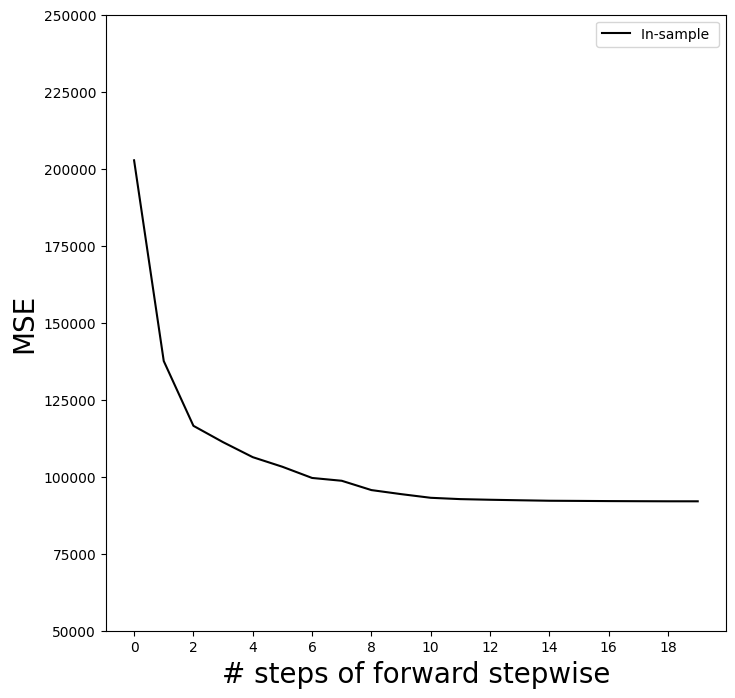

In [ ]:
# Plot in-sample MSE vs. number of steps
mse_fig , ax = subplots (figsize =(8 ,8))

# Calculate in-sample MSE for each step
insample_mse = (( Yhat_in - Y[:, None ]) **2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps), 
    insample_mse, 
    'k', # color black
    label='In-sample '
)
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend ()
ax.set_ylim([50000 ,250000]);

Cross-validation can now be used to estimate test error along the model path. Only the training observations are used to perform all aspects of model-fitting.

In [ ]:
K = 5

kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(
    full_path,
    Hitters,
    Y,
    cv=kfold
)
Yhat_cv.shape